In [274]:
# Import Libraries
import os
import sys

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
from uncertainties import ufloat
import warnings


# Add the src directory to the path to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import parse_sample_pits


In [275]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [276]:
# Collect General Pit Info
pit_info = []

for pit in all_pits:
    pit_info_dict = {
        # User info
        'pit_id': pit.core_info.pit_id,
        # Location info
        'pit_near_avalanche': pit.core_info.location.pit_near_avalanche,
        'pit_near_avalanche_location': pit.core_info.location.pit_near_avalanche_location if pit.core_info.location.pit_near_avalanche_location else None,
        # Weak Layer
        'identified_layer_of_concern': any(layer.layer_of_concern is True for layer in pit.snow_profile.layers) if pit.snow_profile.layers else None,
        # Stability Tests
        'num_CT': len(pit.stability_tests.CT),
        'num_ECT': len(pit.stability_tests.ECT),
        'num_PST': len(pit.stability_tests.PST),
        # Snowpit info

    }
    pit_info.append(pit_info_dict)
    
pit_df = pd.DataFrame(pit_info)

#print(pit_df.head())


In [277]:
## Summary Stats

# Total Pits
print(f"Total Pits: {len(pit_df)}")

# Number of Pits Near Avalanches
pits_near_avalanches = pit_df[(pit_df['pit_near_avalanche'] == True)]
print(f"Number of Pits Near Avalanches: {len(pits_near_avalanches)}")

# Number of Pits on Crowns
pits_on_crowns = pit_df[pit_df['pit_near_avalanche_location'] == 'crown']
print(f"Number of Pits on Crowns: {len(pits_on_crowns)}")

# Number of Pits on Flanks
pits_on_flanks = pit_df[pit_df['pit_near_avalanche_location'] == 'flank']
print(f"Number of Pits on Flanks: {len(pits_on_flanks)}")

# Number of Pits on Crowns and Flanks
print(f"Number of Pits on Crowns and Flanks: {len(pits_on_crowns) + len(pits_on_flanks)}")

# Number of pits with identified layer of concern
pits_with_layer_of_concern = pit_df[pit_df['identified_layer_of_concern'] == True]
print(f"Number of pits with identified layer of concern: {len(pits_with_layer_of_concern)}")

# Number of Pits with CT results
pits_with_CT_results = pit_df[pit_df['num_CT'] > 0]
print(f"Number of Pits with CT results: {len(pits_with_CT_results)}")

# Number of CT results 
print(f"Number of CT results: {sum(pit_df['num_CT'])}")

# Number of Pits with ECT results
pits_with_ECT_results = pit_df[pit_df['num_ECT'] > 0]
print(f"Number of Pits with ECT results: {len(pits_with_ECT_results)}")

# Number of ECT results
print(f"Number of ECT results: {sum(pit_df['num_ECT'])}")

# Number of Pits with PST results
pits_with_PST_results = pit_df[pit_df['num_PST'] > 0]
print(f"Number of Pits with PST results: {len(pits_with_PST_results)}")

# Number of PST results
print(f"Number of PST results: {sum(pit_df['num_PST'])}")


Total Pits: 50278
Number of Pits Near Avalanches: 1568
Number of Pits on Crowns: 795
Number of Pits on Flanks: 399
Number of Pits on Crowns and Flanks: 1194
Number of pits with identified layer of concern: 36408
Number of Pits with CT results: 28959
Number of CT results: 51599
Number of Pits with ECT results: 34327
Number of ECT results: 47684
Number of Pits with PST results: 5154
Number of PST results: 6213


## Dataset Construction

### Datasets Created:
- **'all_pits_loc'**: All indicated layers of concern across entire dataset
- **'pits_on_crowns_loc'**: Indicated layers of concern from pits on avalanche crowns
- **'pits_on_flanks_loc'**: Indicated layers of concern from pits on avalanche flanks
- **'CT_failure_layer'**: Failure layers for CT tests with 'Q1', 'SC' or 'SP' fracture character
- **'ECTP_failure_layer'**: Failure layers for ECT tests with propagation
- **'PST_failure_layer'**: Failure layers for PST tests


In [278]:
# Helper functions for safe value extraction (used by both extraction functions)
def get_value_safe(obj):
    """Safely extract value from object that might be None, scalar, or array-like."""
    if obj is None:
        return None
    if isinstance(obj, (list, tuple, np.ndarray)):
        return obj[0] if len(obj) > 0 else None
    return obj

def extract_layer_dict(layer, pit_id, dataset_name):
    """
    Extract layer information into a dictionary.
    Shared by both layers of concern and failure layer extraction.
    """
    return {
        'pit_id': pit_id,
        'dataset': dataset_name,
        'depth_top': get_value_safe(layer.depth_top),
        'thickness': get_value_safe(layer.thickness),
        'hardness': layer.hardness if layer.hardness else None,
        #'wetness': layer.wetness if layer.wetness else None,
        'grain_form_primary_grain_form': layer.grain_form_primary.grain_form if layer.grain_form_primary else None,
        #'grain_from_primary_grain_size': get_value_safe(layer.grain_form_primary.grain_size_avg) if layer.grain_form_primary and layer.grain_form_primary.grain_size_avg else None,
        #'grain_form_secondary_grain_form': layer.grain_form_secondary.grain_form if layer.grain_form_secondary else None,
        #'grain_from_secondary_grain_size': get_value_safe(layer.grain_form_secondary.grain_size_avg) if layer.grain_form_secondary and layer.grain_form_secondary.grain_size_avg else None,
        'is_layer_of_concern': layer.layer_of_concern if layer.layer_of_concern else None,
    }


In [279]:
def extract_layers_of_concern(pits, filter_location=None):
    """
    Extract indicated layer of concern from pits.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    filter_location : str, optional
        Filter by location: 'crown', 'flank', or None for all
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with layers of concern data
    """
    layers_of_concern = []
    # Map filter_location to dataset names
    if filter_location == 'crown':
        dataset_name = 'pits_on_crowns_loc'
    elif filter_location == 'flank':
        dataset_name = 'pits_on_flanks_loc'
    else:
        dataset_name = 'all_pits_loc'
    
    for pit in pits:
        # Apply location filter if specified
        if filter_location and pit.core_info.location.pit_near_avalanche_location != filter_location:
            continue
        
        # Extract all layers of concern from this pit
        if pit.snow_profile.layers:
            for layer in pit.snow_profile.layers:
                if layer.layer_of_concern is True:
                    layers_of_concern.append(extract_layer_dict(layer, pit.core_info.pit_id, dataset_name))
    
    return pd.DataFrame(layers_of_concern)


In [280]:
def extract_layers_of_failure(pits, test):
    """
    Extract layers where a specific stability test type failed.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    test : str
        Test type: 'CT', 'ECT', or 'PST'
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with failure layers data for the specified test type
        
    Notes:
    ------
    - CT: Includes only tests with fracture character 'Q1', 'SC', or 'SP'
    - ECT: Includes only tests with propagation (ECTP)
      - Checks both propagation attribute and test_score field for 'ECTP'
    - PST: Includes all PST tests
    """
    if test not in ['CT', 'ECT', 'PST']:
        raise ValueError(f"Invalid test type: {test}. Must be 'CT', 'ECT', or 'PST'")
    
    failure_layers = []
    # For ECT, we specifically look for propagation (ECTP), so name it accordingly
    dataset_name = "ECTP_failure_layer" if test == 'ECT' else f"{test}_failure_layer"
    
    for pit in pits:
        layers = pit.snow_profile.layers if pit.snow_profile.layers else []
        if not layers:
            continue
            
        pit_id = pit.core_info.pit_id
        tests = getattr(pit.stability_tests, test)
        
        for test_obj in tests:
            # Apply test-specific filters
            if test == 'CT' and test_obj.fracture_character not in ['Q1', 'SC', 'SP']:
                continue
            
            if test == 'ECT':
                # Check for propagation in both attribute and test_score
                has_propagation = (
                    (hasattr(test_obj, 'propagation') and test_obj.propagation is True) or
                    (hasattr(test_obj, 'test_score') and test_obj.test_score and 'ECTP' in str(test_obj.test_score))
                )
                if not has_propagation:
                    continue
            
            test_depth = get_value_safe(test_obj.depth_top)
            if test_depth is None:
                continue
            
            # Find matching layer by depth
            for layer in layers:
                layer_depth_top = get_value_safe(layer.depth_top)
                layer_thickness = get_value_safe(layer.thickness)
                
                if layer_depth_top is not None and layer_thickness is not None:
                    if layer_depth_top <= test_depth <= layer_depth_top + layer_thickness:
                        failure_layers.append(extract_layer_dict(layer, pit_id, dataset_name))
                        break
    
    return pd.DataFrame(failure_layers)


In [281]:
## Construct all datasets 

# Extract layers of concern
all_layers_df = extract_layers_of_concern(all_pits, filter_location=None)
crowns_layers_df = extract_layers_of_concern(all_pits, filter_location='crown')
flanks_layers_df = extract_layers_of_concern(all_pits, filter_location='flank')

# Extract failure layers for CT and ECT failures 
ct_layers = extract_layers_of_failure(all_pits, 'CT')
ect_layers = extract_layers_of_failure(all_pits, 'ECT')
all_failure_layers_df = pd.concat([ct_layers, ect_layers], ignore_index=True)

# Combine all datasets with dataset labels for comparison
all_datasets_df = pd.concat([
    all_layers_df,
    crowns_layers_df,
    flanks_layers_df,
    ct_layers,
    ect_layers,
], ignore_index=True)

print(f"\nAll Identified Layers of Concern: {len(all_layers_df)}")
print(f"    - Pits on Crowns Layers: {len(crowns_layers_df)}")
print(f"    - Pits on Flanks Layers: {len(flanks_layers_df)}")
print(f"\nStability Test Failure Layers: {len(all_failure_layers_df)}")
print(f"  - CT failures: {len(all_failure_layers_df[all_failure_layers_df['dataset'] == 'CT_failure_layer'])}")
print(f"  - ECTP failures: {len(all_failure_layers_df[all_failure_layers_df['dataset'] == 'ECTP_failure_layer'])}")
print(f"\nTotal layers in combined dataset: {len(all_datasets_df)}")

#all_datasets_df.to_csv('all_layer_df.csv', index=False)



All Identified Layers of Concern: 36409
    - Pits on Crowns Layers: 715
    - Pits on Flanks Layers: 356

Stability Test Failure Layers: 35134
  - CT failures: 19928
  - ECTP failures: 15206

Total layers in combined dataset: 72614


## Analysis

## Layer Depth

DEPTH STATISTICS COMPARISON
           dataset  total_layers      mean  median    max  min       std
      all_pits_loc         36409 49.347336    43.0 497.08  0.0 35.768390
pits_on_crowns_loc           715 65.480909    59.5 377.00  0.0 38.591858
pits_on_flanks_loc           356 54.031180    48.0 320.00  0.0 37.762505
  CT_failure_layer         19928 36.876090    31.0 204.40  0.0 30.513629
ECTP_failure_layer         15206 38.383900    35.0 225.00  0.0 26.486506


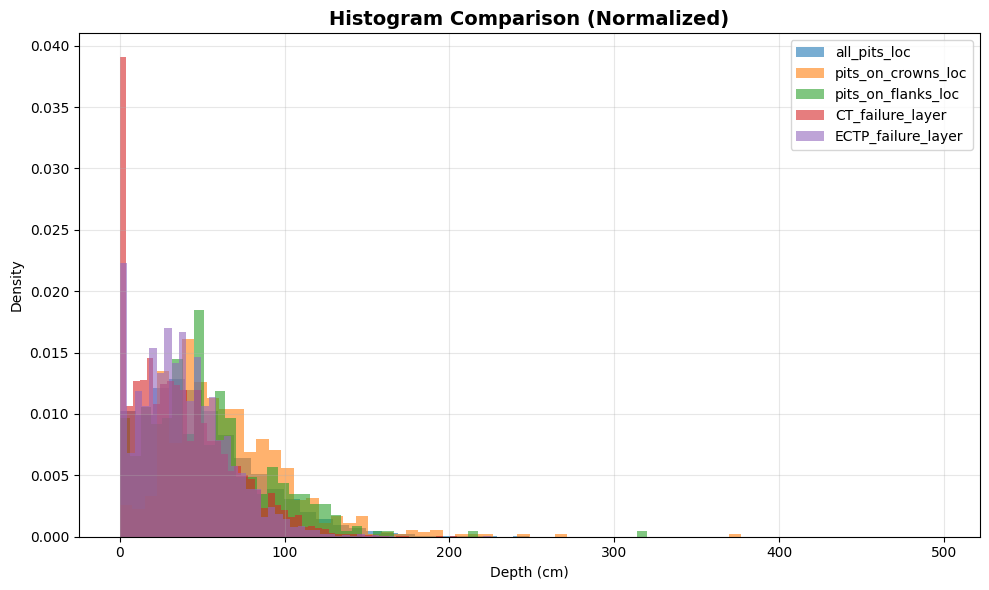

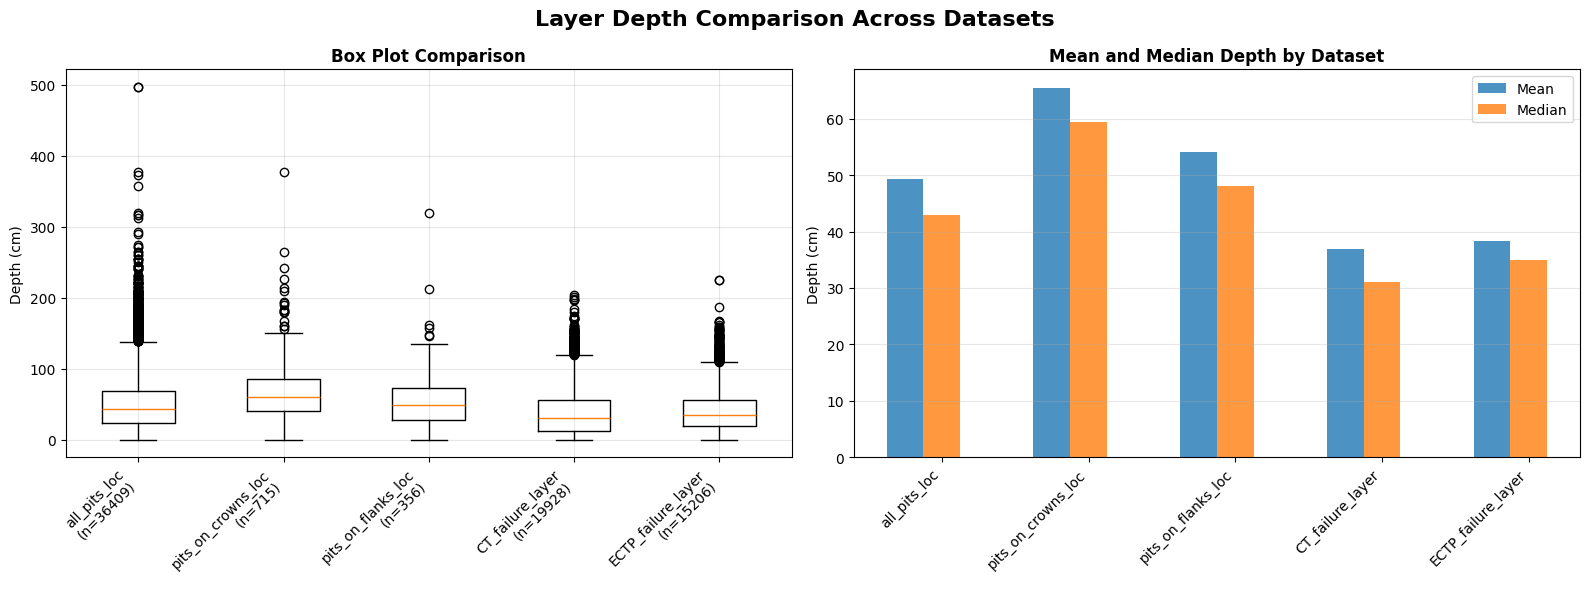

In [282]:
def analyze_depth(df, dataset_name):
    """Analyze depth statistics for a dataset."""
    valid_depth = df[df['depth_top'].notna()]['depth_top']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'mean': valid_depth.mean() if len(valid_depth) > 0 else None,
        'median': valid_depth.median() if len(valid_depth) > 0 else None,
        'max': valid_depth.max() if len(valid_depth) > 0 else None,
        'min': valid_depth.min() if len(valid_depth) > 0 else None,
        'std': valid_depth.std() if len(valid_depth) > 0 else None,
    }
    return stats, valid_depth

def compare_depth_across_datasets(all_datasets_df):
    """Compare depth statistics and create visualizations across datasets."""
    datasets = {
        'all_pits_loc': all_datasets_df[all_datasets_df['dataset'] == 'all_pits_loc'],
        'pits_on_crowns_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_crowns_loc'],
        'pits_on_flanks_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_flanks_loc'],
        'CT_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'CT_failure_layer'],
        'ECTP_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'ECTP_failure_layer'],
    }
    
    # Calculate statistics
    stats_list = []
    depth_data = {}
    for name, df in datasets.items():
        stats, depths = analyze_depth(df, name)
        stats_list.append(stats)
        depth_data[name] = depths
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("DEPTH STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Create normalized histogram as separate figure
    fig1 = plt.figure(figsize=(10, 6))
    for name, depths in depth_data.items():
        if len(depths) > 0:
            plt.hist(depths, bins=50, alpha=0.6, label=name, density=True)
    plt.title('Histogram Comparison (Normalized)', fontsize=14, fontweight='bold')
    plt.xlabel('Depth (cm)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create comparison visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Layer Depth Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Box plot comparison with sample sizes
    depth_list = [depths.values for depths in depth_data.values() if len(depths) > 0]
    labels_list = [name for name, depths in depth_data.items() if len(depths) > 0]
    sample_sizes = [len(depths) for depths in depth_data.values() if len(depths) > 0]
    
    axes[0].boxplot(depth_list, tick_labels=labels_list)
    axes[0].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Depth (cm)')
    
    # Add sample sizes below labels
    labels_with_n = [f'{label}\n(n={n})' for label, n in zip(labels_list, sample_sizes)]
    axes[0].set_xticks(range(1, len(labels_with_n) + 1))
    axes[0].set_xticklabels(labels_with_n, rotation=45, ha='right')
    axes[0].grid(alpha=0.3)
    
    # Statistics bar chart
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1].bar(x - width, stats_df['mean'], width, label='Mean', alpha=0.8)
    axes[1].bar(x, stats_df['median'], width, label='Median', alpha=0.8)
    axes[1].set_title('Mean and Median Depth by Dataset', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Depth (cm)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
depth_stats = compare_depth_across_datasets(all_datasets_df)


## Thickness

THICKNESS STATISTICS COMPARISON
           dataset  total_layers      mean  median   max  min       std
      all_pits_loc         36409 13.085122     8.0 250.0 0.01 14.427496
pits_on_crowns_loc           715  9.813776     5.0 111.0 0.10 12.696035
pits_on_flanks_loc           356 13.051124     8.0  80.0 0.10 14.226350
  CT_failure_layer         19928 18.036013    15.0 270.0 0.20 15.899226
ECTP_failure_layer         15206 16.081776    13.0 150.0 0.10 14.158407


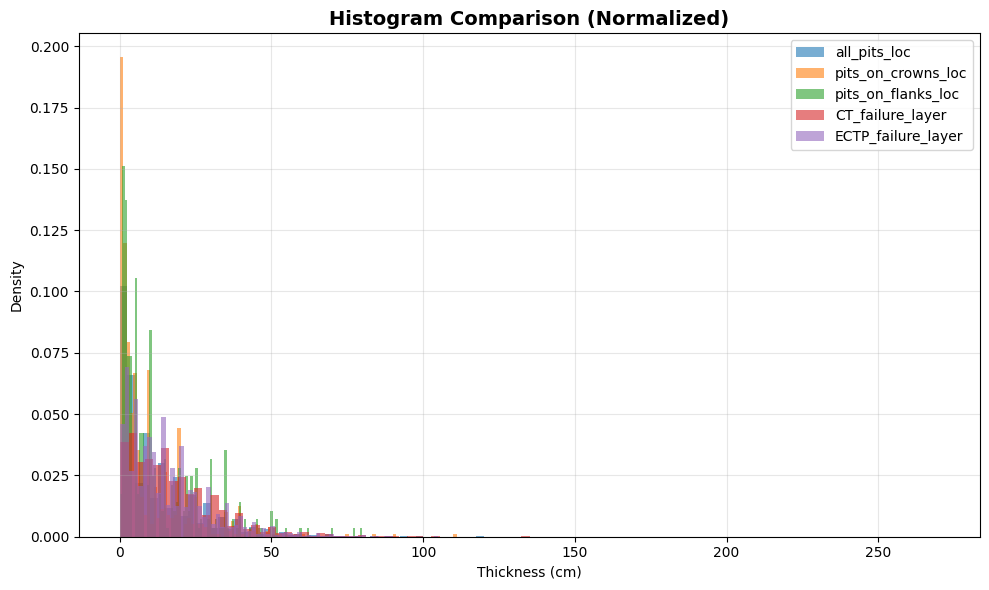

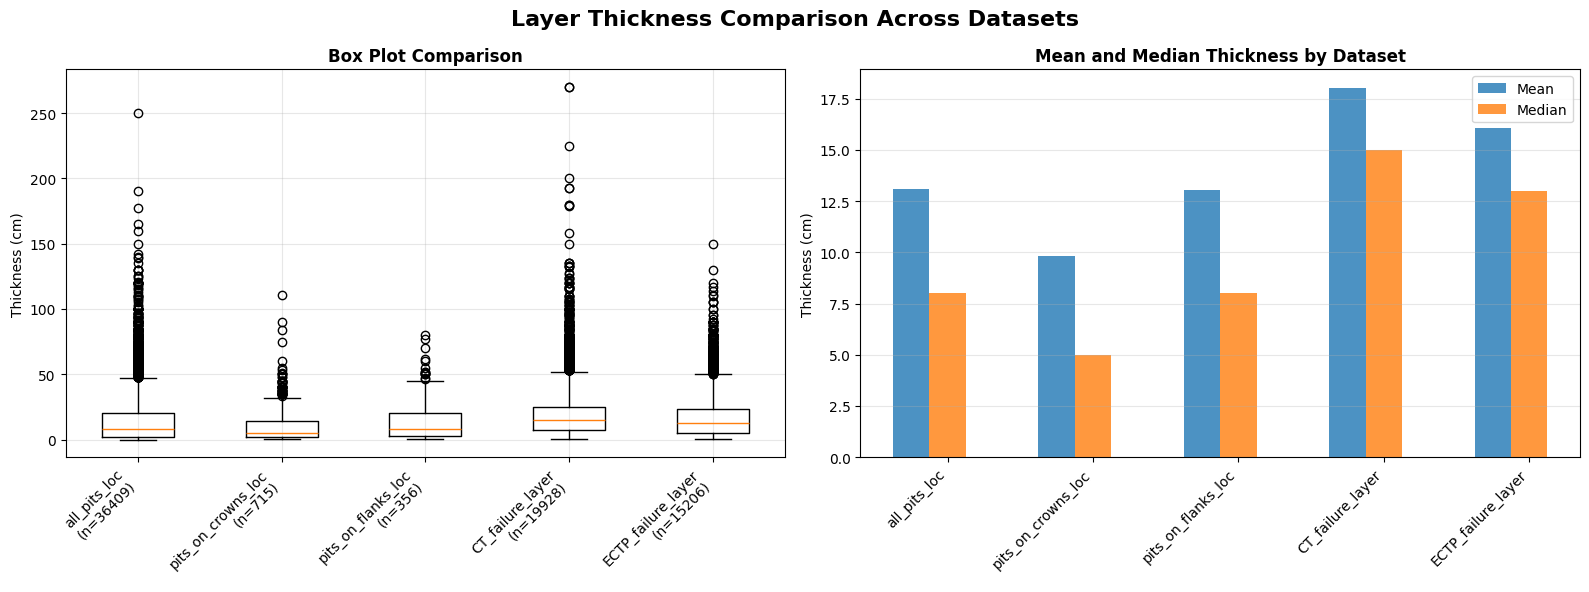

In [283]:
def analyze_thickness(df, dataset_name):
    """Analyze thickness statistics for a dataset."""
    valid_thickness = df[df['thickness'].notna()]['thickness']
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'mean': valid_thickness.mean() if len(valid_thickness) > 0 else None,
        'median': valid_thickness.median() if len(valid_thickness) > 0 else None,
        'max': valid_thickness.max() if len(valid_thickness) > 0 else None,
        'min': valid_thickness.min() if len(valid_thickness) > 0 else None,
        'std': valid_thickness.std() if len(valid_thickness) > 0 else None,
    }
    return stats, valid_thickness

def compare_thickness_across_datasets(all_datasets_df):
    """Compare thickness statistics and create visualizations across datasets."""
    datasets = {
        'all_pits_loc': all_datasets_df[all_datasets_df['dataset'] == 'all_pits_loc'],
        'pits_on_crowns_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_crowns_loc'],
        'pits_on_flanks_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_flanks_loc'],
        'CT_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'CT_failure_layer'],
        'ECTP_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'ECTP_failure_layer'],
    }
    
    # Calculate statistics
    stats_list = []
    thickness_data = {}
    for name, df in datasets.items():
        stats, thicknesses = analyze_thickness(df, name)
        stats_list.append(stats)
        thickness_data[name] = thicknesses
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("THICKNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Create normalized histogram as separate figure
    fig1 = plt.figure(figsize=(10, 6))
    for name, thicknesses in thickness_data.items():
        if len(thicknesses) > 0:
            plt.hist(thicknesses, bins=100, alpha=0.6, label=name, density=True)
    plt.title('Histogram Comparison (Normalized)', fontsize=14, fontweight='bold')
    plt.xlabel('Thickness (cm)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create comparison visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Layer Thickness Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Box plot comparison with sample sizes
    thickness_list = [thicknesses.values for thicknesses in thickness_data.values() if len(thicknesses) > 0]
    labels_list = [name for name, thicknesses in thickness_data.items() if len(thicknesses) > 0]
    sample_sizes = [len(thicknesses) for thicknesses in thickness_data.values() if len(thicknesses) > 0]
    
    axes[0].boxplot(thickness_list, tick_labels=labels_list)
    axes[0].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Thickness (cm)')
    
    # Add sample sizes below labels
    labels_with_n = [f'{label}\n(n={n})' for label, n in zip(labels_list, sample_sizes)]
    axes[0].set_xticks(range(1, len(labels_with_n) + 1))
    axes[0].set_xticklabels(labels_with_n, rotation=45, ha='right')
    axes[0].grid(alpha=0.3)
    
    # Statistics bar chart
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1].bar(x - width, stats_df['mean'], width, label='Mean', alpha=0.8)
    axes[1].bar(x, stats_df['median'], width, label='Median', alpha=0.8)
    axes[1].set_title('Mean and Median Thickness by Dataset', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Thickness (cm)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
thickness_stats = compare_thickness_across_datasets(all_datasets_df)


## Hand Hardness

HARDNESS STATISTICS COMPARISON
           dataset  total_layers  layers_with_hardness  layers_with_numeric_hardness  percentage  mean_numeric  median_numeric  min_numeric  max_numeric  std_numeric
      all_pits_loc         36409                 33114                         33114   90.950040      2.165405            2.00         0.67         6.33     1.255163
pits_on_crowns_loc           715                   662                           662   92.587413      1.885529            1.67         0.67         6.00     1.038336
pits_on_flanks_loc           356                   326                           326   91.573034      1.986840            2.00         0.67         6.00     1.130382
  CT_failure_layer         19928                 17624                         17624   88.438378      2.486895            2.33         0.67         6.33     1.179055
ECTP_failure_layer         15206                 13321                         13321   87.603578      2.450205            2.00         0.67

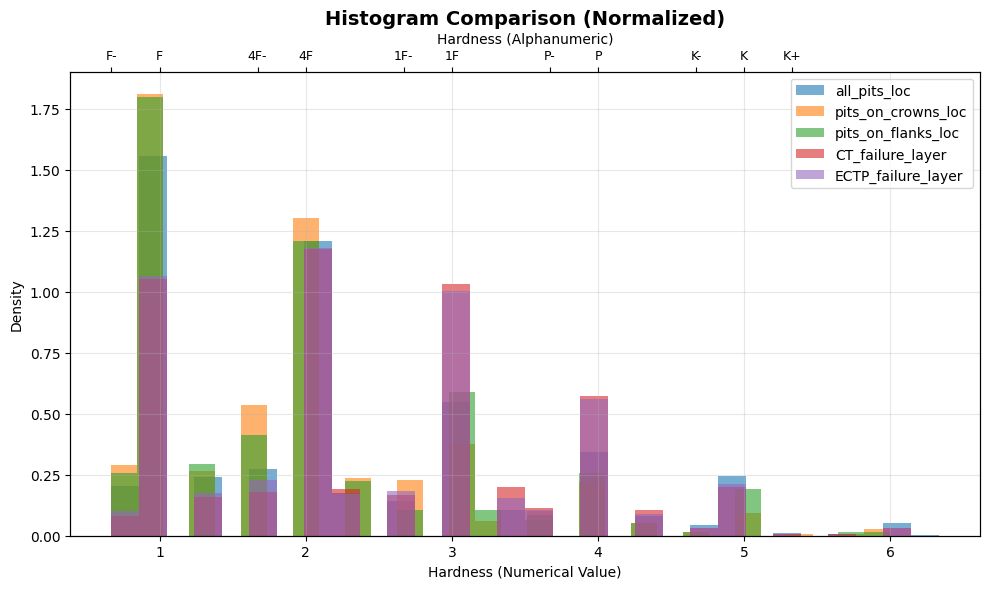

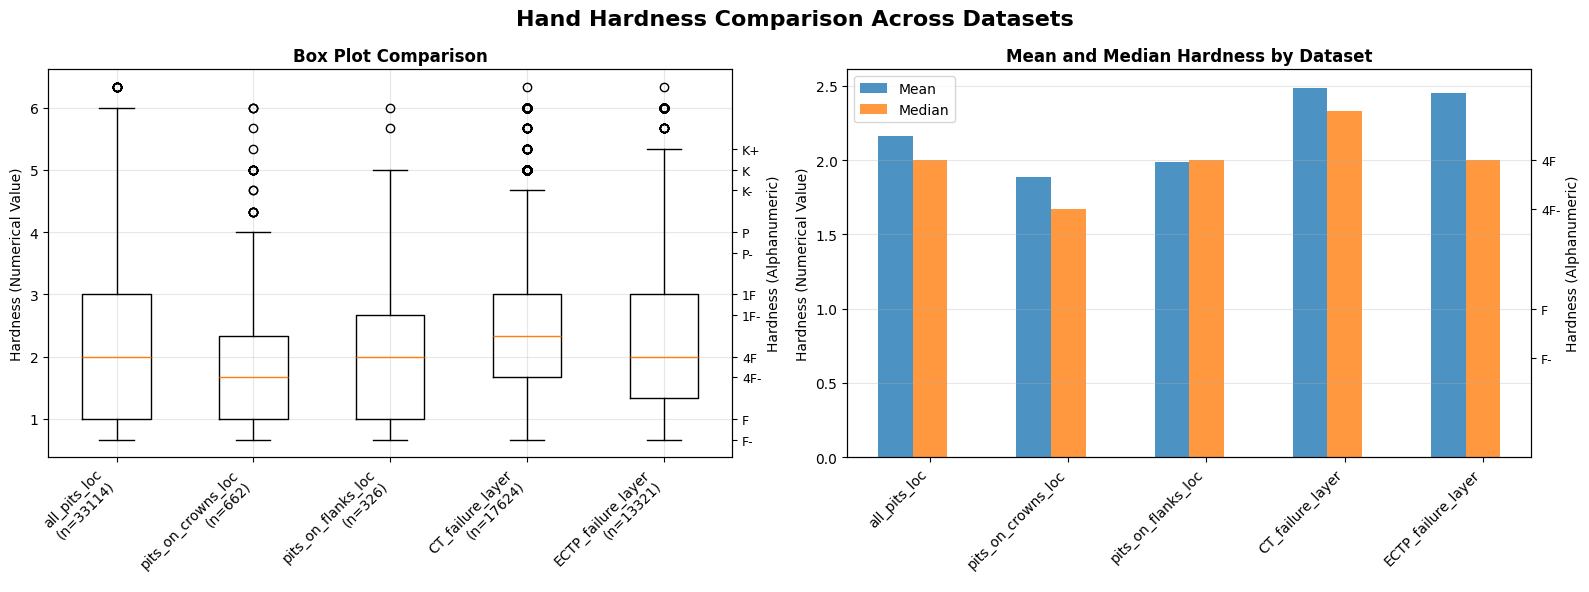

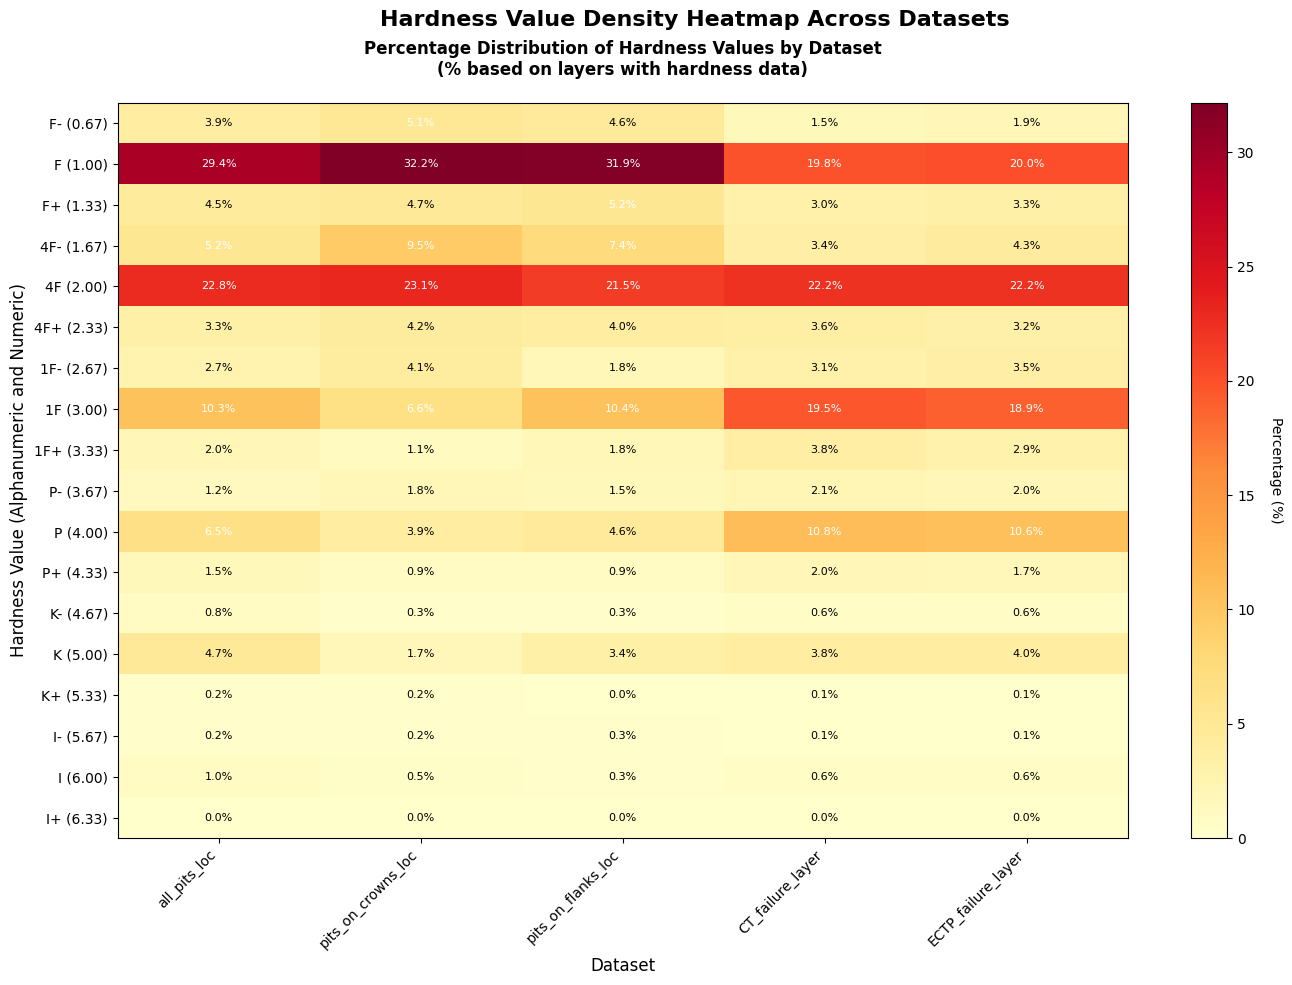

In [284]:
# Hand hardness mapping to numerical values
HARDNESS_MAPPING = {
    'F-': 0.67, 'F': 1.0, 'F+': 1.33,
    '4F-': 1.67, '4F': 2.0, '4F+': 2.33,
    '1F-': 2.67, '1F': 3.0, '1F+': 3.33,
    'P-': 3.67, 'P': 4.0, 'P+': 4.33,
    'K-': 4.67, 'K': 5.0, 'K+': 5.33,
    'I-': 5.67, 'I': 6.0, 'I+': 6.33,
}

def map_hardness_to_numeric(hardness_str):
    """Convert alphanumerical hardness to numerical value."""
    if pd.isna(hardness_str):
        return None
    return HARDNESS_MAPPING.get(str(hardness_str), None)

def analyze_hardness(df, dataset_name):
    """Analyze hardness statistics for a dataset."""
    valid_hardness = df[df['hardness'].notna()]['hardness']
    
    # Convert to numerical values
    df_with_numeric = df[df['hardness'].notna()].copy()
    df_with_numeric['hardness_numeric'] = df_with_numeric['hardness'].apply(map_hardness_to_numeric)
    valid_hardness_numeric = df_with_numeric[df_with_numeric['hardness_numeric'].notna()]['hardness_numeric']
    
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_hardness': len(valid_hardness),
        'layers_with_numeric_hardness': len(valid_hardness_numeric),
        'percentage': len(valid_hardness) / len(df) * 100 if len(df) > 0 else 0,
        'mean_numeric': valid_hardness_numeric.mean() if len(valid_hardness_numeric) > 0 else None,
        'median_numeric': valid_hardness_numeric.median() if len(valid_hardness_numeric) > 0 else None,
        'min_numeric': valid_hardness_numeric.min() if len(valid_hardness_numeric) > 0 else None,
        'max_numeric': valid_hardness_numeric.max() if len(valid_hardness_numeric) > 0 else None,
        'std_numeric': valid_hardness_numeric.std() if len(valid_hardness_numeric) > 0 else None,
    }
    return stats, valid_hardness, valid_hardness_numeric

def compare_hardness_across_datasets(all_datasets_df):
    """Compare hardness statistics and create visualizations across datasets."""
    datasets = {
        'all_pits_loc': all_datasets_df[all_datasets_df['dataset'] == 'all_pits_loc'],
        'pits_on_crowns_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_crowns_loc'],
        'pits_on_flanks_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_flanks_loc'],
        'CT_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'CT_failure_layer'],
        'ECTP_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'ECTP_failure_layer'],
    }
    
    # Calculate statistics
    stats_list = []
    hardness_data = {}
    hardness_numeric_data = {}
    for name, df in datasets.items():
        stats, hardnesses, hardnesses_numeric = analyze_hardness(df, name)
        stats_list.append(stats)
        hardness_data[name] = hardnesses
        hardness_numeric_data[name] = hardnesses_numeric
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("HARDNESS STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Frequency counts for each dataset in table format
    print("\n" + "="*80)
    print("HARDNESS FREQUENCY BY DATASET")
    print("="*80)
    
    # Get all unique hardness values across all datasets
    all_hardness_values = set()
    for hardnesses in hardness_data.values():
        if len(hardnesses) > 0:
            all_hardness_values.update(hardnesses.unique())
    
    # Sort by numerical value
    hardness_with_numeric = [(h, map_hardness_to_numeric(h)) for h in all_hardness_values]
    hardness_with_numeric = [(h, num) for h, num in hardness_with_numeric if num is not None]
    hardness_with_numeric.sort(key=lambda x: x[1])
    sorted_hardness_values = [h for h, _ in hardness_with_numeric]
    
    # Build frequency table
    freq_table_data = []
    for hardness_val in sorted_hardness_values:
        row = {'Hardness': hardness_val, 'Numeric': map_hardness_to_numeric(hardness_val)}
        for name, hardnesses in hardness_data.items():
            if len(hardnesses) > 0:
                count = hardnesses.value_counts().get(hardness_val, 0)
                percentage = (count / len(hardnesses) * 100) if len(hardnesses) > 0 else 0
                row[f'{name}_qty'] = count
                row[f'{name}_%'] = percentage
        freq_table_data.append(row)
    
    freq_table_df = pd.DataFrame(freq_table_data)
    
    # Reorder columns for better readability
    column_order = ['Hardness', 'Numeric']
    for name in hardness_data.keys():
        column_order.append(f'{name}_qty')
        column_order.append(f'{name}_%')
    freq_table_df = freq_table_df[column_order]
    
    # Format percentage columns to 2 decimal places
    for col in freq_table_df.columns:
        if col.endswith('_%'):
            freq_table_df[col] = freq_table_df[col].apply(lambda x: f'{x:.2f}')
    
    print(freq_table_df.to_string(index=False))
    print()
    
    # Create normalized histogram as separate figure
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    for name, hardnesses_numeric in hardness_numeric_data.items():
        if len(hardnesses_numeric) > 0:
            ax1.hist(hardnesses_numeric, bins=30, alpha=0.6, label=name, density=True)
    ax1.set_title('Histogram Comparison (Normalized)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Hardness (Numerical Value)')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Add secondary x-axis with hardness letter labels
    ax1_top = ax1.twiny()
    ax1_top.set_xlim(ax1.get_xlim())
    # Create tick positions and labels for main hardness values
    hardness_ticks = [0.67, 1.0, 1.67, 2.0, 2.67, 3.0, 3.67, 4.0, 4.67, 5.0, 5.33]
    hardness_labels = ['F-', 'F', '4F-', '4F', '1F-', '1F', 'P-', 'P', 'K-', 'K', 'K+']
    ax1_top.set_xticks(hardness_ticks)
    ax1_top.set_xticklabels(hardness_labels, fontsize=9)
    ax1_top.set_xlabel('Hardness (Alphanumeric)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Create comparison visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Hand Hardness Comparison Across Datasets', fontsize=16, fontweight='bold')
    
    # Box plot comparison with sample sizes
    hardness_numeric_list = [h.values for h in hardness_numeric_data.values() if len(h) > 0]
    labels_list = [name for name, h in hardness_numeric_data.items() if len(h) > 0]
    sample_sizes = [len(h) for h in hardness_numeric_data.values() if len(h) > 0]
    
    axes[0].boxplot(hardness_numeric_list, tick_labels=labels_list)
    axes[0].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Hardness (Numerical Value)')
    
    # Add sample sizes below labels
    labels_with_n = [f'{label}\n(n={n})' for label, n in zip(labels_list, sample_sizes)]
    axes[0].set_xticks(range(1, len(labels_with_n) + 1))
    axes[0].set_xticklabels(labels_with_n, rotation=45, ha='right')
    axes[0].grid(alpha=0.3)
    
    # Add secondary y-axis with hardness letter labels
    ax0_right = axes[0].twinx()
    ax0_right.set_ylim(axes[0].get_ylim())
    hardness_ticks = [0.67, 1.0, 1.67, 2.0, 2.67, 3.0, 3.67, 4.0, 4.67, 5.0, 5.33]
    hardness_labels = ['F-', 'F', '4F-', '4F', '1F-', '1F', 'P-', 'P', 'K-', 'K', 'K+']
    ax0_right.set_yticks(hardness_ticks)
    ax0_right.set_yticklabels(hardness_labels, fontsize=9)
    ax0_right.set_ylabel('Hardness (Alphanumeric)', fontsize=10)
    
    # Statistics bar chart
    x = np.arange(len(stats_df))
    width = 0.25
    axes[1].bar(x - width, stats_df['mean_numeric'], width, label='Mean', alpha=0.8)
    axes[1].bar(x, stats_df['median_numeric'], width, label='Median', alpha=0.8)
    axes[1].set_title('Mean and Median Hardness by Dataset', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Hardness (Numerical Value)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(stats_df['dataset'], rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(alpha=0.3, axis='y')
    
    # Add secondary y-axis with hardness letter labels
    ax1_right = axes[1].twinx()
    hardness_ticks = [0.67, 1.0, 1.67, 2.0, 2.67, 3.0, 3.67, 4.0, 4.67, 5.0, 5.33]
    hardness_labels = ['F-', 'F', '4F-', '4F', '1F-', '1F', 'P-', 'P', 'K-', 'K', 'K+']
    ax1_right.set_yticks(hardness_ticks)
    ax1_right.set_yticklabels(hardness_labels, fontsize=9)
    ax1_right.set_ylabel('Hardness (Alphanumeric)', fontsize=10)
    
    plt.tight_layout()
    
    # Ensure secondary y-axis aligns with primary axis after tight_layout
    ax1_right.set_ylim(axes[1].get_ylim())
    
    plt.show()
    
    # Create heatmap showing density of hardness values across datasets
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    fig.suptitle('Hardness Value Density Heatmap Across Datasets', fontsize=16, fontweight='bold')
    
    # Prepare data for heatmap using the frequency table data
    # Get all unique hardness values and sort by numeric value
    all_hardness_vals = set()
    for hardnesses in hardness_data.values():
        if len(hardnesses) > 0:
            all_hardness_vals.update(hardnesses.unique())
    
    # Separate hardness values with and without numeric mappings
    hardness_with_mapping = []
    hardness_without_mapping = []
    for h in all_hardness_vals:
        num = map_hardness_to_numeric(h)
        if num is not None:
            hardness_with_mapping.append((h, num))
        else:
            hardness_without_mapping.append(h)
    
    # Sort those with mappings by numeric value, and sort those without alphabetically
    hardness_with_mapping.sort(key=lambda x: x[1])
    hardness_without_mapping.sort()
    
    # Combine: mapped values first, then unmapped values
    hardness_values_sorted = [h for h, _ in hardness_with_mapping] + hardness_without_mapping
    
    # Build matrix for heatmap (percentage values based on layers with hardness data)
    heatmap_data = []
    dataset_names = list(hardness_data.keys())
    
    for hardness_val in hardness_values_sorted:
        row = []
        for name in dataset_names:
            hardnesses = hardness_data[name]
            if len(hardnesses) > 0:
                count = hardnesses.value_counts().get(hardness_val, 0)
                percentage = (count / len(hardnesses) * 100)
                row.append(percentage)
            else:
                row.append(0)
        heatmap_data.append(row)
    
    # Create heatmap
    heatmap_array = np.array(heatmap_data)
    
    im = ax.imshow(heatmap_array, cmap='YlOrRd', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(dataset_names)))
    ax.set_yticks(np.arange(len(hardness_values_sorted)))
    ax.set_xticklabels(dataset_names, rotation=45, ha='right')
    
    # Create y-axis labels with both alphanumeric and numeric values
    y_labels = []
    for h in hardness_values_sorted:
        num_val = map_hardness_to_numeric(h)
        if num_val is not None:
            y_labels.append(f'{h} ({num_val:.2f})')
        else:
            y_labels.append(f'{h} (no mapping)')
    ax.set_yticklabels(y_labels)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)', rotation=270, labelpad=20)
    
    # Add text annotations
    for i in range(len(hardness_values_sorted)):
        for j in range(len(dataset_names)):
            text = ax.text(j, i, f'{heatmap_array[i, j]:.1f}%',
                          ha="center", va="center", color="black" if heatmap_array[i, j] < 5 else "white",
                          fontsize=8)
    
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel('Hardness Value (Alphanumeric and Numeric)', fontsize=12)
    ax.set_title('Percentage Distribution of Hardness Values by Dataset\n(% based on layers with hardness data)', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
hardness_stats = compare_hardness_across_datasets(all_datasets_df)


## Grain Form

GRAIN FORM STATISTICS COMPARISON
           dataset  total_layers  layers_with_grain_form  percentage
      all_pits_loc         36409                   33153   91.057156
pits_on_crowns_loc           715                     679   94.965035
pits_on_flanks_loc           356                     329   92.415730
  CT_failure_layer         19928                   16450   82.547170
ECTP_failure_layer         15206                   13036   85.729317

MAIN GRAIN FORM FREQUENCY BY DATASET
Grain_Form  all_pits_loc_qty all_pits_loc_%  pits_on_crowns_loc_qty pits_on_crowns_loc_%  pits_on_flanks_loc_qty pits_on_flanks_loc_%  CT_failure_layer_qty CT_failure_layer_%  ECTP_failure_layer_qty ECTP_failure_layer_%
        DF              2687           8.10                      40                 5.89                      33                10.03                  3285              19.97                    1965                15.07
        DH              3084           9.30                      54        

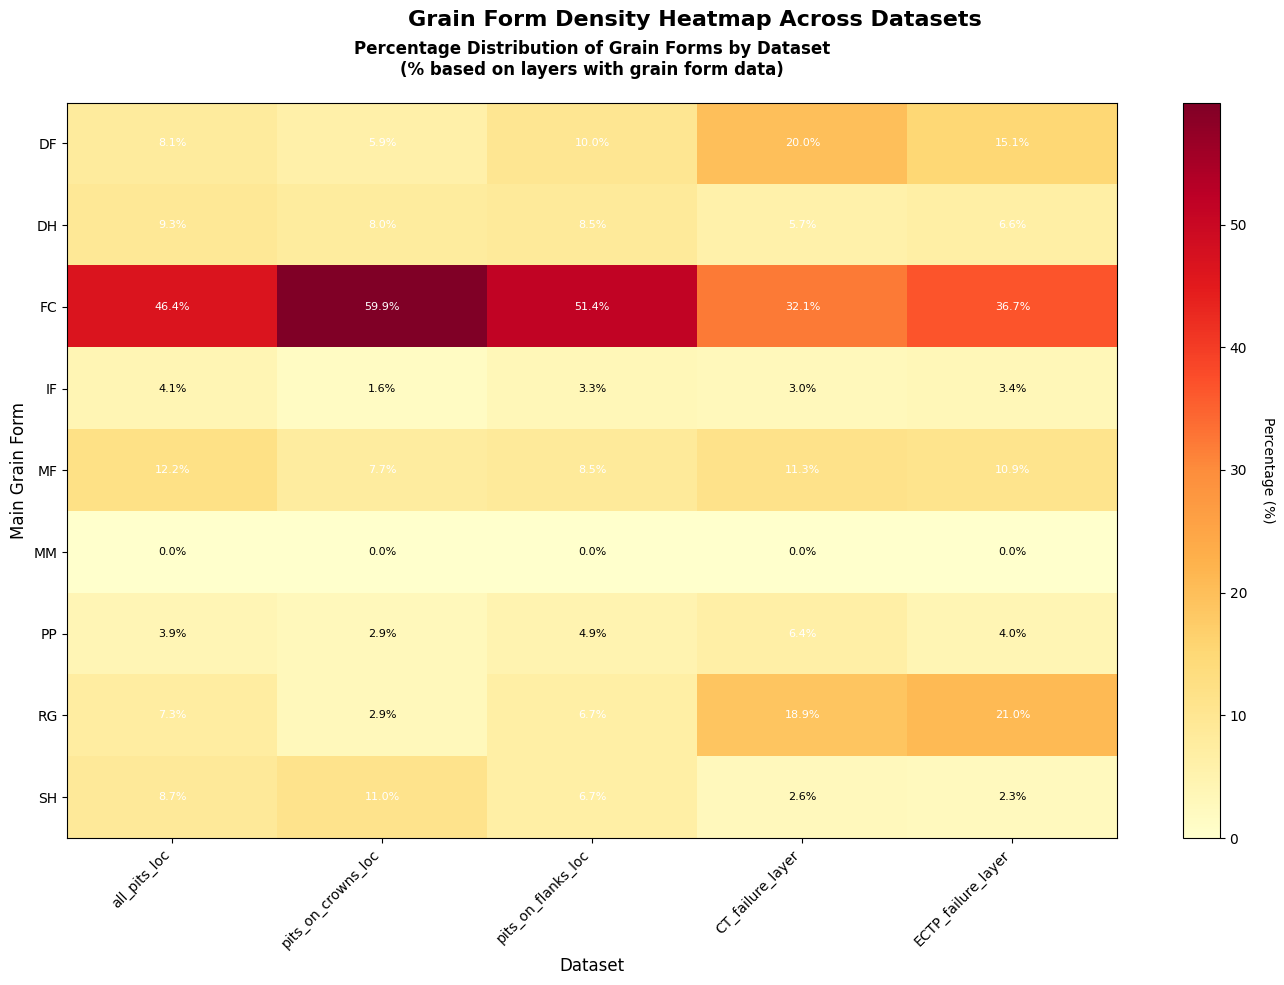

In [285]:
def analyze_grain_forms(df, dataset_name):
    """Analyze grain form statistics for a dataset."""
    # Get layers with valid grain form data
    valid_grain_form = df[df['grain_form_primary_grain_form'].notna()].copy()
    
    # Extract main grain form (first 2 characters)
    if len(valid_grain_form) > 0:
        valid_grain_form['main_grain_form'] = valid_grain_form['grain_form_primary_grain_form'].str[:2]
        main_grain_forms = valid_grain_form['main_grain_form']
    else:
        main_grain_forms = pd.Series(dtype=str)
    
    stats = {
        'dataset': dataset_name,
        'total_layers': len(df),
        'layers_with_grain_form': len(valid_grain_form),
        'percentage': len(valid_grain_form) / len(df) * 100 if len(df) > 0 else 0,
    }
    return stats, main_grain_forms

def compare_grain_forms_across_datasets(all_datasets_df):
    """Compare grain form statistics and create visualizations across datasets."""
    datasets = {
        'all_pits_loc': all_datasets_df[all_datasets_df['dataset'] == 'all_pits_loc'],
        'pits_on_crowns_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_crowns_loc'],
        'pits_on_flanks_loc': all_datasets_df[all_datasets_df['dataset'] == 'pits_on_flanks_loc'],
        'CT_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'CT_failure_layer'],
        'ECTP_failure_layer': all_datasets_df[all_datasets_df['dataset'] == 'ECTP_failure_layer'],
    }
    
    # Calculate statistics
    stats_list = []
    grain_form_data = {}
    for name, df in datasets.items():
        stats, main_grain_forms = analyze_grain_forms(df, name)
        stats_list.append(stats)
        grain_form_data[name] = main_grain_forms
    
    stats_df = pd.DataFrame(stats_list)
    print("="*80)
    print("GRAIN FORM STATISTICS COMPARISON")
    print("="*80)
    print(stats_df.to_string(index=False))
    
    # Frequency counts for each dataset in table format
    print("\n" + "="*80)
    print("MAIN GRAIN FORM FREQUENCY BY DATASET")
    print("="*80)
    
    # Get all unique grain forms across all datasets
    all_grain_forms = set()
    for grain_forms in grain_form_data.values():
        if len(grain_forms) > 0:
            all_grain_forms.update(grain_forms.unique())
    
    # Sort alphabetically
    sorted_grain_forms = sorted(list(all_grain_forms))
    
    # Build frequency table
    freq_table_data = []
    for grain_form in sorted_grain_forms:
        row = {'Grain_Form': grain_form}
        for name, grain_forms in grain_form_data.items():
            if len(grain_forms) > 0:
                count = grain_forms.value_counts().get(grain_form, 0)
                percentage = (count / len(grain_forms) * 100) if len(grain_forms) > 0 else 0
                row[f'{name}_qty'] = count
                row[f'{name}_%'] = percentage
        freq_table_data.append(row)
    
    freq_table_df = pd.DataFrame(freq_table_data)
    
    # Reorder columns for better readability
    column_order = ['Grain_Form']
    for name in grain_form_data.keys():
        column_order.append(f'{name}_qty')
        column_order.append(f'{name}_%')
    freq_table_df = freq_table_df[column_order]
    
    # Format percentage columns to 2 decimal places
    for col in freq_table_df.columns:
        if col.endswith('_%'):
            freq_table_df[col] = freq_table_df[col].apply(lambda x: f'{x:.2f}')
    
    print(freq_table_df.to_string(index=False))
    print()
    
    # Create heatmap showing density of grain forms across datasets
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    fig.suptitle('Grain Form Density Heatmap Across Datasets', fontsize=16, fontweight='bold')
    
    # Build matrix for heatmap (percentage values based on layers with grain form data)
    heatmap_data = []
    dataset_names = list(grain_form_data.keys())
    
    for grain_form in sorted_grain_forms:
        row = []
        for name in dataset_names:
            grain_forms = grain_form_data[name]
            if len(grain_forms) > 0:
                count = grain_forms.value_counts().get(grain_form, 0)
                percentage = (count / len(grain_forms) * 100)
                row.append(percentage)
            else:
                row.append(0)
        heatmap_data.append(row)
    
    # Create heatmap
    heatmap_array = np.array(heatmap_data)
    
    # Verify column sums (should be 100% for each dataset)
    print("\nHeatmap column sums (should be ~100% for each dataset):")
    for j, name in enumerate(dataset_names):
        col_sum = heatmap_array[:, j].sum()
        print(f"  {name}: {col_sum:.2f}%")
    
    im = ax.imshow(heatmap_array, cmap='YlOrRd', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(dataset_names)))
    ax.set_yticks(np.arange(len(sorted_grain_forms)))
    ax.set_xticklabels(dataset_names, rotation=45, ha='right')
    ax.set_yticklabels(sorted_grain_forms)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)', rotation=270, labelpad=20)
    
    # Add text annotations
    for i in range(len(sorted_grain_forms)):
        for j in range(len(dataset_names)):
            text = ax.text(j, i, f'{heatmap_array[i, j]:.1f}%',
                          ha="center", va="center", color="black" if heatmap_array[i, j] < 5 else "white",
                          fontsize=8)
    
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel('Main Grain Form', fontsize=12)
    ax.set_title('Percentage Distribution of Grain Forms by Dataset\n(% based on layers with grain form data)', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Perform comparison analysis
grain_form_stats = compare_grain_forms_across_datasets(all_datasets_df)


## Stability Test Failure Layers

**In pits with an indicated layer of concern:**
- How often is there an ECTP result on the indicated layer of concern?
- How often is there an ECTP result on a different layer than the indicated layer of concern?
- How often is there an ECTN or ECTX result on the indicated layer of concern?
- How often is there a CT result with fracture character 'Q1', 'SC', or 'SP' on the indicated layer of concern?
- How often is there a CT result with a facture character 'Q1', 'SC', or 'SP' on a different layer than the indicated layer of concern?
- How often is there a CT result with a fracture character other than 'Q1', 'SC', or 'SP' on the indicated layer of concern?

In [291]:
def analyze_stability_tests_on_loc(pits, location_filter=None):
    """
    Analyze stability test results on identified layers of concern.
    
    Parameters:
    -----------
    pits : list
        List of pit objects
    location_filter : str or list, optional
        Filter by location: 'crown', 'flank', ['crown', 'flank'], or None for all pits
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with analysis results including counts and percentages
    """
    # Filter pits based on location and presence of layers of concern
    if location_filter is None:
        # All pits with identified layers of concern
        filtered_pits = [
            pit for pit in pits 
            if any(layer.layer_of_concern is True for layer in pit.snow_profile.layers if pit.snow_profile.layers)
        ]
    elif isinstance(location_filter, list):
        # Multiple locations (e.g., ['crown', 'flank'])
        filtered_pits = [
            pit for pit in pits 
            if pit.core_info.location.pit_near_avalanche_location in location_filter
            and any(layer.layer_of_concern is True for layer in pit.snow_profile.layers if pit.snow_profile.layers)
        ]
    else:
        # Single location (e.g., 'crown' or 'flank')
        filtered_pits = [
            pit for pit in pits 
            if pit.core_info.location.pit_near_avalanche_location == location_filter
            and any(layer.layer_of_concern is True for layer in pit.snow_profile.layers if pit.snow_profile.layers)
        ]
    
    # Initialize counters
    results = {
        'ectp_on_loc': 0,
        'ectp_on_different': 0,
        'ectn_ectx_on_loc': 0,
        'ct_q1_sc_sp_on_loc': 0,
        'ct_q1_sc_sp_on_different': 0,
        'ct_other_on_loc': 0,
        'pits_with_ect': 0,
        'pits_with_ct': 0,
        'total_pits': len(filtered_pits)
    }
    
    # Analyze each pit
    for pit in filtered_pits:
        # Get layers of concern depths
        loc_depths = []
        for layer in pit.snow_profile.layers:
            if layer.layer_of_concern is True:
                depth = get_value_safe(layer.depth_top)
                if depth is not None:
                    loc_depths.append(depth)
        
        if not loc_depths:
            continue
        
        # Check ECT results
        if pit.stability_tests.ECT:
            results['pits_with_ect'] += 1
            for ect in pit.stability_tests.ECT:
                test_depth = get_value_safe(ect.depth_top)
                if test_depth is not None:
                    # Check if ECTP (propagation)
                    has_propagation = (
                        (hasattr(ect, 'propagation') and ect.propagation is True) or
                        (hasattr(ect, 'test_score') and ect.test_score and 'ECTP' in str(ect.test_score))
                    )
                    
                    if has_propagation:
                        # Check if on layer of concern (within 2cm tolerance)
                        on_loc = any(abs(test_depth - loc_depth) <= 2 for loc_depth in loc_depths)
                        if on_loc:
                            results['ectp_on_loc'] += 1
                        else:
                            results['ectp_on_different'] += 1
                    else:
                        # Non-propagating tests (ECTN or ECTX)
                        on_loc = any(abs(test_depth - loc_depth) <= 2 for loc_depth in loc_depths)
                        if on_loc:
                            results['ectn_ectx_on_loc'] += 1
        
        # Check CT results
        if pit.stability_tests.CT:
            results['pits_with_ct'] += 1
            for ct in pit.stability_tests.CT:
                test_depth = get_value_safe(ct.depth_top)
                if test_depth is not None and ct.fracture_character:
                    on_loc = any(abs(test_depth - loc_depth) <= 2 for loc_depth in loc_depths)
                    
                    # Check if Q1, SC, or SP
                    if ct.fracture_character in ['Q1', 'SC', 'SP']:
                        if on_loc:
                            results['ct_q1_sc_sp_on_loc'] += 1
                        else:
                            results['ct_q1_sc_sp_on_different'] += 1
                    else:
                        # Other fracture character
                        if on_loc:
                            results['ct_other_on_loc'] += 1
    
    # Calculate percentages
    if results['pits_with_ect'] > 0:
        results['ectp_on_loc_pct'] = results['ectp_on_loc'] / results['pits_with_ect'] * 100
        results['ectp_on_different_pct'] = results['ectp_on_different'] / results['pits_with_ect'] * 100
        results['ectn_ectx_on_loc_pct'] = results['ectn_ectx_on_loc'] / results['pits_with_ect'] * 100
    else:
        results['ectp_on_loc_pct'] = 0
        results['ectp_on_different_pct'] = 0
        results['ectn_ectx_on_loc_pct'] = 0
    
    if results['pits_with_ct'] > 0:
        results['ct_q1_sc_sp_on_loc_pct'] = results['ct_q1_sc_sp_on_loc'] / results['pits_with_ct'] * 100
        results['ct_q1_sc_sp_on_different_pct'] = results['ct_q1_sc_sp_on_different'] / results['pits_with_ct'] * 100
        results['ct_other_on_loc_pct'] = results['ct_other_on_loc'] / results['pits_with_ct'] * 100
    else:
        results['ct_q1_sc_sp_on_loc_pct'] = 0
        results['ct_q1_sc_sp_on_different_pct'] = 0
        results['ct_other_on_loc_pct'] = 0
    
    # Convert to DataFrame
    df = pd.DataFrame([results])
    
    return df


In [294]:
# Analysis: Stability Test Results on Identified Layers of Concern

# Use function to get results for all pits with LOC
results_df = analyze_stability_tests_on_loc(all_pits, location_filter=None)

# Use function to get results for pits on crowns and flanks
results_cf_df = analyze_stability_tests_on_loc(all_pits, location_filter=['crown', 'flank'])


In [293]:
# Extract values from both dataframes
# All pits
total_pits = results_df['total_pits'].values[0]
pits_with_ect = results_df['pits_with_ect'].values[0]
pits_with_ct = results_df['pits_with_ct'].values[0]
ectp_on_loc = results_df['ectp_on_loc'].values[0]
ectp_on_different = results_df['ectp_on_different'].values[0]
ectn_ectx_on_loc = results_df['ectn_ectx_on_loc'].values[0]
ct_q1_sc_sp_on_loc = results_df['ct_q1_sc_sp_on_loc'].values[0]
ct_q1_sc_sp_on_different = results_df['ct_q1_sc_sp_on_different'].values[0]
ct_other_on_loc = results_df['ct_other_on_loc'].values[0]

# Crowns and Flanks
total_pits_cf = results_cf_df['total_pits'].values[0]
pits_with_ect_cf = results_cf_df['pits_with_ect'].values[0]
pits_with_ct_cf = results_cf_df['pits_with_ct'].values[0]
ectp_on_loc_cf = results_cf_df['ectp_on_loc'].values[0]
ectp_on_different_cf = results_cf_df['ectp_on_different'].values[0]
ectn_ectx_on_loc_cf = results_cf_df['ectn_ectx_on_loc'].values[0]
ct_q1_sc_sp_on_loc_cf = results_cf_df['ct_q1_sc_sp_on_loc'].values[0]
ct_q1_sc_sp_on_different_cf = results_cf_df['ct_q1_sc_sp_on_different'].values[0]
ct_other_on_loc_cf = results_cf_df['ct_other_on_loc'].values[0]

# Display side-by-side comparison
print("="*120)
print("STABILITY TEST RESULTS COMPARISON: ALL PITS vs CROWNS & FLANKS")
print("="*120)

# Summary statistics
print(f"\n{'Metric':<60} {'All Pits':>25} {'Crowns & Flanks':>25}")
print("-"*120)
print(f"{'Total pits with identified layer of concern':<60} {total_pits:>25} {total_pits_cf:>25}")
print(f"{'Pits with ECT tests':<60} {f'{pits_with_ect} ({pits_with_ect/total_pits*100:.1f}%)':>25} {f'{pits_with_ect_cf} ({pits_with_ect_cf/total_pits_cf*100:.1f}%)':>25}")
print(f"{'Pits with CT tests':<60} {f'{pits_with_ct} ({pits_with_ct/total_pits*100:.1f}%)':>25} {f'{pits_with_ct_cf} ({pits_with_ct_cf/total_pits_cf*100:.1f}%)':>25}")

# ECT Results
print("\n" + "="*120)
print(f"ECT RESULTS (% of pits with ECT tests)")
print("="*120)
print(f"{'Metric':<60} {'All Pits':>25} {'Crowns & Flanks':>25}")
print("-"*120)
if pits_with_ect > 0 and pits_with_ect_cf > 0:
    print(f"{'ECTP on identified layer of concern':<60} {f'{ectp_on_loc} ({ectp_on_loc/pits_with_ect*100:.1f}%)':>25} {f'{ectp_on_loc_cf} ({ectp_on_loc_cf/pits_with_ect_cf*100:.1f}%)':>25}")
    print(f"{'ECTP on different layer':<60} {f'{ectp_on_different} ({ectp_on_different/pits_with_ect*100:.1f}%)':>25} {f'{ectp_on_different_cf} ({ectp_on_different_cf/pits_with_ect_cf*100:.1f}%)':>25}")
    print(f"{'ECTN or ECTX on identified layer of concern':<60} {f'{ectn_ectx_on_loc} ({ectn_ectx_on_loc/pits_with_ect*100:.1f}%)':>25} {f'{ectn_ectx_on_loc_cf} ({ectn_ectx_on_loc_cf/pits_with_ect_cf*100:.1f}%)':>25}")
else:
    print("Insufficient ECT data for comparison")

# CT Results
print("\n" + "="*120)
print(f"CT RESULTS (% of pits with CT tests)")
print("="*120)
print(f"{'Metric':<60} {'All Pits':>25} {'Crowns & Flanks':>25}")
print("-"*120)
if pits_with_ct > 0 and pits_with_ct_cf > 0:
    print(f"{'CT with Q1/SC/SP on identified layer of concern':<60} {f'{ct_q1_sc_sp_on_loc} ({ct_q1_sc_sp_on_loc/pits_with_ct*100:.1f}%)':>25} {f'{ct_q1_sc_sp_on_loc_cf} ({ct_q1_sc_sp_on_loc_cf/pits_with_ct_cf*100:.1f}%)':>25}")
    print(f"{'CT with Q1/SC/SP on different layer':<60} {f'{ct_q1_sc_sp_on_different} ({ct_q1_sc_sp_on_different/pits_with_ct*100:.1f}%)':>25} {f'{ct_q1_sc_sp_on_different_cf} ({ct_q1_sc_sp_on_different_cf/pits_with_ct_cf*100:.1f}%)':>25}")
    print(f"{'CT with other fracture character on LOC':<60} {f'{ct_other_on_loc} ({ct_other_on_loc/pits_with_ct*100:.1f}%)':>25} {f'{ct_other_on_loc_cf} ({ct_other_on_loc_cf/pits_with_ct_cf*100:.1f}%)':>25}")
else:
    print("Insufficient CT data for comparison")

print("\n" + "="*120)



STABILITY TEST RESULTS COMPARISON: ALL PITS vs CROWNS & FLANKS

Metric                                                                        All Pits           Crowns & Flanks
------------------------------------------------------------------------------------------------------------------------
Total pits with identified layer of concern                                      36408                      1071
Pits with ECT tests                                                      26045 (71.5%)               687 (64.1%)
Pits with CT tests                                                       22082 (60.7%)               441 (41.2%)

ECT RESULTS (% of pits with ECT tests)
Metric                                                                        All Pits           Crowns & Flanks
------------------------------------------------------------------------------------------------------------------------
ECTP on identified layer of concern                                       7633 (29.3%)   

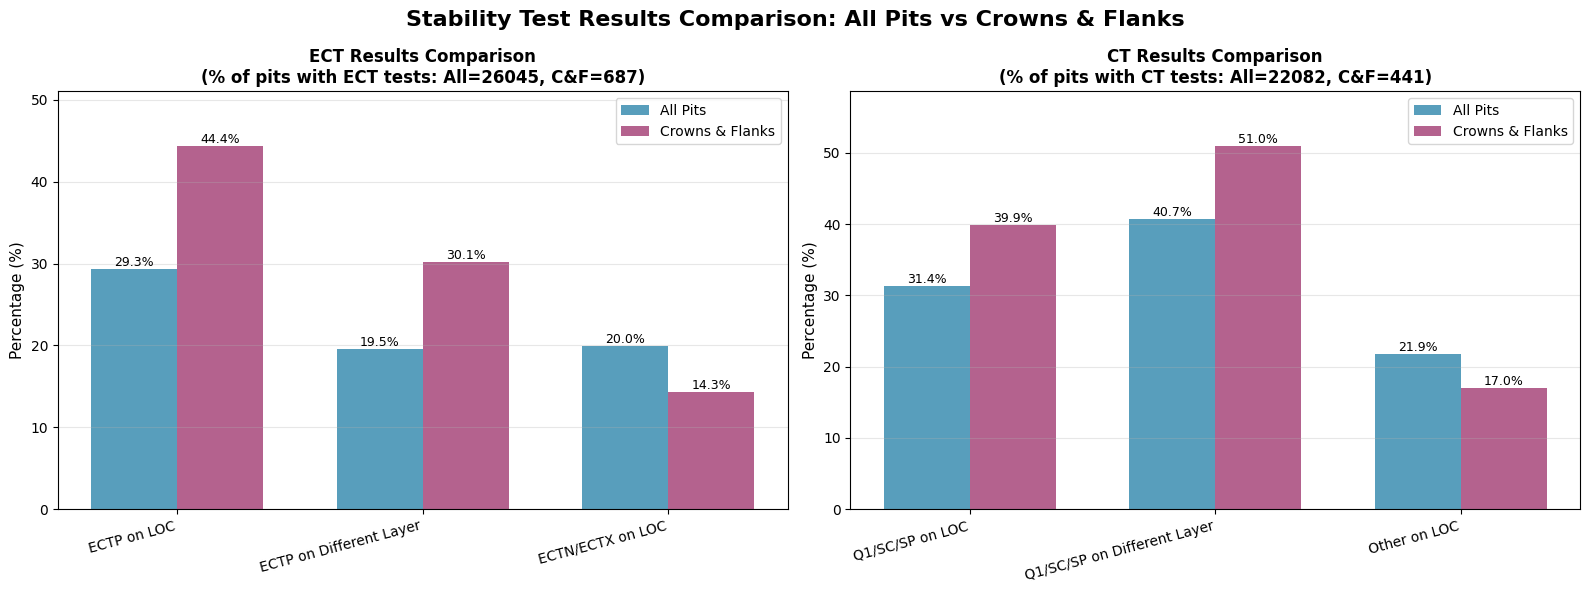

In [296]:
# Visualization: Comparison of ECT and CT Results Between Datasets

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Stability Test Results Comparison: All Pits vs Crowns & Flanks', fontsize=16, fontweight='bold')

# Prepare data for plotting
colors = ['#2E86AB', '#A23B72']
datasets = ['All Pits', 'Crowns & Flanks']

# Calculate percentages for ECT results
ect_metrics = {
    'ECTP on LOC': [
        ectp_on_loc / pits_with_ect * 100 if pits_with_ect > 0 else 0,
        ectp_on_loc_cf / pits_with_ect_cf * 100 if pits_with_ect_cf > 0 else 0
    ],
    'ECTP on Different Layer': [
        ectp_on_different / pits_with_ect * 100 if pits_with_ect > 0 else 0,
        ectp_on_different_cf / pits_with_ect_cf * 100 if pits_with_ect_cf > 0 else 0
    ],
    'ECTN/ECTX on LOC': [
        ectn_ectx_on_loc / pits_with_ect * 100 if pits_with_ect > 0 else 0,
        ectn_ectx_on_loc_cf / pits_with_ect_cf * 100 if pits_with_ect_cf > 0 else 0
    ]
}

# Calculate percentages for CT results
ct_metrics = {
    'Q1/SC/SP on LOC': [
        ct_q1_sc_sp_on_loc / pits_with_ct * 100 if pits_with_ct > 0 else 0,
        ct_q1_sc_sp_on_loc_cf / pits_with_ct_cf * 100 if pits_with_ct_cf > 0 else 0
    ],
    'Q1/SC/SP on Different Layer': [
        ct_q1_sc_sp_on_different / pits_with_ct * 100 if pits_with_ct > 0 else 0,
        ct_q1_sc_sp_on_different_cf / pits_with_ct_cf * 100 if pits_with_ct_cf > 0 else 0
    ],
    'Other on LOC': [
        ct_other_on_loc / pits_with_ct * 100 if pits_with_ct > 0 else 0,
        ct_other_on_loc_cf / pits_with_ct_cf * 100 if pits_with_ct_cf > 0 else 0
    ]
}

# Plot 1: ECT Results Comparison
ax1 = axes[0]
x = np.arange(len(ect_metrics))
width = 0.35

for i, dataset in enumerate(datasets):
    values = [ect_metrics[metric][i] for metric in ect_metrics.keys()]
    bars = ax1.bar(x + i*width - width/2, values, width, label=dataset, color=colors[i], alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

ax1.set_title(f'ECT Results Comparison\n(% of pits with ECT tests: All={pits_with_ect}, C&F={pits_with_ect_cf})', 
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(ect_metrics.keys(), rotation=15, ha='right')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylim(0, max([max(v) for v in ect_metrics.values()]) * 1.15)

# Plot 2: CT Results Comparison
ax2 = axes[1]
x = np.arange(len(ct_metrics))

for i, dataset in enumerate(datasets):
    values = [ct_metrics[metric][i] for metric in ct_metrics.keys()]
    bars = ax2.bar(x + i*width - width/2, values, width, label=dataset, color=colors[i], alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.set_title(f'CT Results Comparison\n(% of pits with CT tests: All={pits_with_ct}, C&F={pits_with_ct_cf})', 
              fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(ct_metrics.keys(), rotation=15, ha='right')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3, axis='y')
ax2.set_ylim(0, max([max(v) for v in ct_metrics.values()]) * 1.15)

plt.tight_layout()
plt.show()


## Summary of Analysis Results

